# Tutorial Ocean Parcels
https://oceanparcels.org/#tutorials

- https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/parcels_tutorial.ipynb
-https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_parcels_structure.ipynb
- https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_output.ipynb

sampleo de Temperatura y salinidad
- https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_sampling.ipynb?flush_cache=true


## Descargar datos de Copernicus

https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/download?dataset=cmems_mod_glo_phy-wcur_anfc_0.083deg_P1M-m




-----

In [29]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
# import math
from datetime import timedelta
from datetime import datetime
import xarray as xr

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt

In [81]:
cmems = xr.load_dataset('cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1677578663683.nc')

In [82]:
cmems

<xarray.Dataset>
Dimensions:    (time: 673, depth: 1, latitude: 145, longitude: 253)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 5.0 5.083 5.167 5.25 ... 16.83 16.92 17.0
  * time       (time) datetime64[ns] 2022-02-25T23:30:00 ... 2022-03-25T23:30:00
  * longitude  (longitude) float32 -76.0 -75.92 -75.83 ... -55.17 -55.08 -55.0
Data variables:
    utotal     (time, depth, latitude, longitude) float32 nan nan ... -0.08203
    vsdy       (time, depth, latitude, longitude) float32 nan nan ... -0.04004
    vsdx       (time, depth, latitude, longitude) float32 nan nan ... -0.1104
    vtide      (time, depth, latitude, longitude) float32 nan nan ... -0.01172
    vo         (time, depth, latitude, longitude) float32 nan nan ... -0.03418
    uo         (time, depth, latitude, longitude) float32 nan nan ... 0.02148
    vtotal     (time, depth, latitude, longitude) float32 nan nan ... -0.08594
    utide      (time, depth, latitude, longitude) float32 nan nan ... 0.005859
Attributes: (12/15)
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    title:                         hourly mean merged surface currents from o...
    area:                          GLOBAL
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    licence:                       http://marine.copernicus.eu/services-portf...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    institution:                   MERCATOR OCEAN
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [4]:
variables = {'U': 'utotal',
             'V': 'vtotal',
            'T': 'thetao',
             'S': 'so'}
            
dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
             'T':  {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
             'S': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

data_uv = 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1677578663683.nc'
data_TS = 'cmems_mod_glo_phy_anfc_0.083deg_PT1H-m_1677580373578.nc'


filenames = {'U': data_uv,
             'V': data_uv,
             'T': data_TS,
            'S': data_TS}


In [5]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

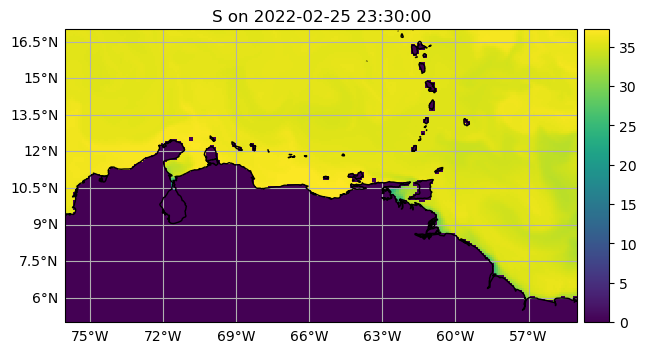

In [6]:
fieldset.S.show()

In [7]:
n_points = 40
lon_sample = -60
lat_sample = 11

lon_cluster = [lon_sample]*n_points + np.random.normal(loc=0, scale=0.05, size=n_points)
lat_cluster = [lat_sample]*n_points + np.random.normal(loc=0, scale=0.05, size=n_points)
lon_cluster = np.array(lon_cluster) 
lat_cluster = np.array(lat_cluster)

In [8]:

start_time = datetime.strptime('2022-02-26 12:00:00', '%Y-%m-%d %H:%M:%S')
date_cluster = [start_time]*n_points

In [9]:
class Parcela(JITParticle):
    Temp = Variable('Temp', dtype=np.float32,
                                initial=0)
    Sa = Variable('Sa', dtype=np.float32,
                            initial=0)

In [10]:
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=Parcela,  # the type of particles (JITParticle or ScipyParticle)
                             lon=lon_cluster, # a vector of release longitudes 
                             lat=lat_cluster,
                            time=date_cluster)    # a vector of release latitudes


# Kernel de Sampleo T-S

In [11]:
def SampleField(particle, fieldset, time):
    particle.Temp = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.Sa = fieldset.S[time, particle.depth, particle.lat, particle.lon]

In [12]:
sample_kernel = pset.Kernel(SampleField)

In [13]:
pset.execute(sample_kernel, dt=0)

INFO: Compiled ArrayParcelaSampleField ==> /tmp/parcels-1000/libf7bc15891cfda1f9bde1928054277b9c_0.so


In [14]:
pset

P[0](lon=-59.891441, lat=11.096970, depth=0.000000, Temp=27.124187, Sa=35.194664, time=45000.000000)
P[1](lon=-59.985649, lat=11.040905, depth=0.000000, Temp=27.103031, Sa=35.281895, time=45000.000000)
P[2](lon=-59.999180, lat=11.007753, depth=0.000000, Temp=27.095194, Sa=35.305267, time=45000.000000)
P[3](lon=-59.982536, lat=10.925739, depth=0.000000, Temp=27.091839, Sa=35.331581, time=45000.000000)
P[4](lon=-59.943378, lat=11.091817, depth=0.000000, Temp=27.120777, Sa=35.227463, time=45000.000000)
P[5](lon=-59.954651, lat=11.027989, depth=0.000000, Temp=27.106161, Sa=35.270599, time=45000.000000)
P[6](lon=-60.015808, lat=11.013534, depth=0.000000, Temp=27.100285, Sa=35.310867, time=45000.000000)
P[7](lon=-59.999611, lat=10.989206, depth=0.000000, Temp=27.093670, Sa=35.313614, time=45000.000000)
P[8](lon=-60.025997, lat=10.975323, depth=0.000000, Temp=27.101288, Sa=35.329681, time=45000.000000)
P[9](lon=-60.050301, lat=11.128084, depth=0.000000, Temp=27.113344, Sa=35.277054, time=4500

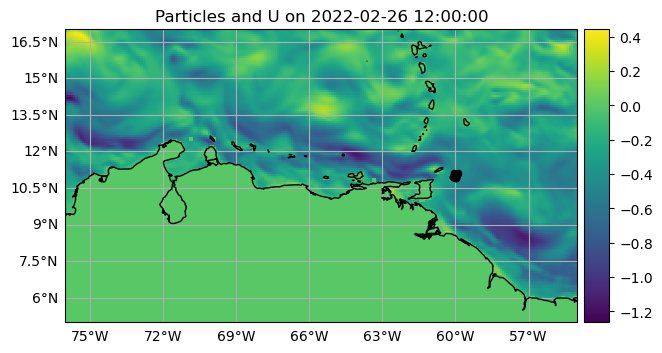

In [15]:
pset.show(field=fieldset.U)

In [16]:
output_file = pset.ParticleFile(name="test_proy4.zarr", outputdt=timedelta(hours=1)) # the file name and the time step of the outputs

In [17]:
pset.execute(AdvectionRK4 + sample_kernel,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=5),    # the total length of the run
             dt=timedelta(hours=1),      # the timestep of the kernel
             output_file=output_file)

INFO: Compiled ArrayParcelaAdvectionRK4SampleField ==> /tmp/parcels-1000/liba9968bcb0d596c3fe185c0964267a7d5_0.so
INFO: Output files are stored in test_proy4.zarr.
100%|██████████| 432000.0/432000.0 [00:41<00:00, 10342.40it/s]


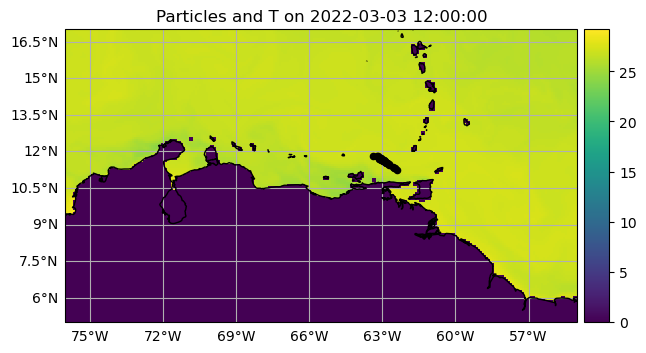

In [18]:
pset.show(field=fieldset.T)

In [24]:
xr.load_dataset(data_TS)

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 145, time: 673, longitude: 253)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 5.0 5.083 5.167 5.25 ... 16.83 16.92 17.0
  * time       (time) datetime64[ns] 2022-02-25T23:30:00 ... 2022-03-25T23:30:00
  * longitude  (longitude) float32 -76.0 -75.92 -75.83 ... -55.17 -55.08 -55.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 nan nan ... 25.62
    so         (time, depth, latitude, longitude) float32 nan nan ... 36.31
Attributes: (12/13)
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    title:             hourly mean fields from Global Ocean Physics Analysis ...
    area:              Global
    Conventions:       CF-1.8
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    ...                ...
    source:            MOI GLO12
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    institution:       Mercator Ocean International
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    comment:           
    history:           Data extracted from dataset http://localhost:8080/thre...

In [ ]:
FieldSet.from_netcdf()

> La funcion `plotTrajectoriesFile` no funciona bien. Le pregunte a Laura y me dice que no es de fiar esa funcion. Para la animacion dirigirse a [Animacion](#Animacion)

# Output - archivo de salida

In [42]:
sim = xr.open_zarr('test_proy4.zarr/')

In [43]:
sim

<xarray.Dataset>
Dimensions:     (trajectory: 40, obs: 121)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119 120
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
Data variables:
    Sa          (trajectory, obs) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    Temp        (trajectory, obs) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(40, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

Text(0, 0.5, 'Latitud')

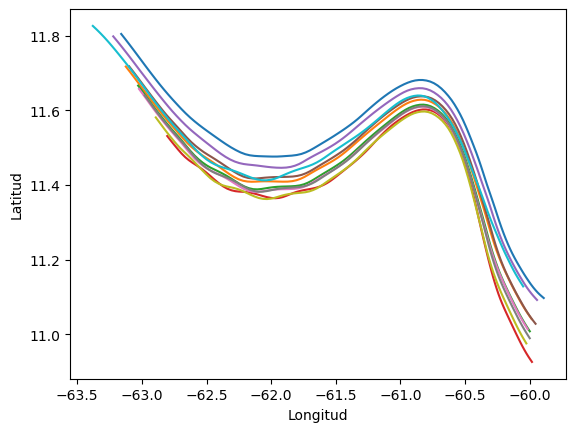

In [91]:
for i in range(10):
    plt.plot(sim['lon'][i,:], sim['lat'][i,:])
    
plt.xlabel('Longitud')
plt.ylabel('Latitud')

In [92]:
temp = sim['Temp'].values
sa = sim['Sa'].values

Text(0.5, 0, 'dt')

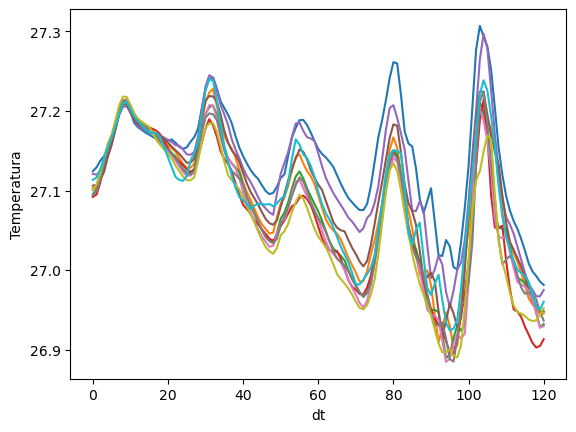

In [93]:
for i in range(10):
    plt.plot(temp[i,:])
    
plt.ylabel('Temperatura')
plt.xlabel('dt')

Text(0.5, 0, 'Salinidad')

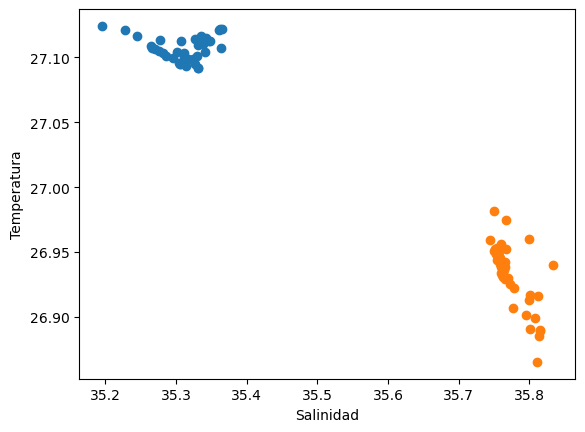

In [95]:
plt.scatter(sa[:,0], temp[:,0])
plt.scatter(sa[:,-1], temp[:,-1])

plt.ylabel('Temperatura')
plt.xlabel('Salinidad')

### Campos de Temperatura y Salinidad

In [96]:
cmems_TS = xr.load_dataset('cmems_mod_glo_phy_anfc_0.083deg_PT1H-m_1677580373578.nc')

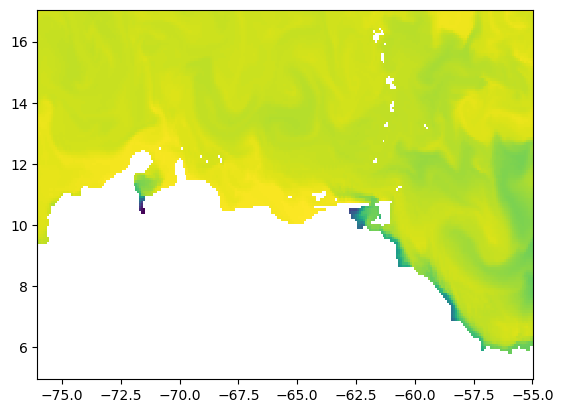

In [97]:
X, Y = np.meshgrid(cmems_TS['longitude'], cmems_TS['latitude'])

plt.pcolormesh(X, Y, cmems_TS['so'][0,0])

# Animacion
Esto sale del tutorial `Output Tutorial` que viene en OceanParcels. Le agregue los campos de velocidades al plot.

In [84]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from datetime import timedelta as delta

outputdt = delta(hours=2)
timerange = np.arange(np.nanmin(sim['time'].values),
                      np.nanmax(sim['time'].values)+np.timedelta64(outputdt), 
                      outputdt)  # timerange in nanoseconds


In [89]:
%%capture
X, Y = np.meshgrid(cmems['longitude'], cmems['latitude'])

fig = plt.figure(figsize=(5,5),constrained_layout=True)
ax = fig.add_subplot()


mesh = ax.pcolormesh(X, Y, cmems['utotal'][0,0])


ax.set_ylabel('Latitud')
ax.set_xlabel('Longitud')

time_id = np.where(sim['time'] == timerange[0]) # Indices of the data where time = 0

scatter = ax.scatter(sim['lon'].values[time_id], sim['lat'].values[time_id], color='red')

t = str(timerange[0].astype('timedelta64[h]'))
title = ax.set_title('Particulas al t = '+t)

def animate(i):
    new_data = cmems['utotal'][i,0].values
    
    # Update the mesh with the new data
    mesh.set_array(new_data.ravel())
    
    t = str(timerange[i].astype('timedelta64[h]'))
    title.set_text('Particles at t = '+t)
    
    time_id = np.where(sim['time'] == timerange[i])
    scatter.set_offsets(np.c_[sim['lon'].values[time_id], sim['lat'].values[time_id]])
    
    return mesh,
    
anim = FuncAnimation(fig, animate, frames = len(timerange), interval=500)

In [90]:
HTML(anim.to_jshtml())